# Aplicando EDA al dataset Taxi Fare

Instalamos las dependencias necesarias para realizar el análisis

In [3]:
!pip install pandas
!pip install seaborn
!pip install tqdm

Importamos los módulos a utilizar posteriormente

```
import pandas as pd
import seaborn as sns
import numpy as np

from multiprocessing import cpu_count, Pool
from math import radians, cos, sin, asin, sqrt
```

In [4]:
import pandas as pd
import seaborn as sns
import numpy as np
from tqdm import tqdm

from multiprocessing import cpu_count, Pool
from math import radians, cos, sin, asin, sqrt

# Esto es solo para la visualización en Pycharm
sns.set_style("ticks")

Inicializamos algunas constantes a utilizar

* **FILE_PATH:** Contiene la ruta de nuestro dataset.
* **EARTH_RADIUS:** Es el valor promedio del radio de la Tierra en kilómetros.
* **CHUNK_SIZE:** Indica el tamaño del conjunto de datos que se procesará en cada iteración.
* **AVAILABLE_CPUS:** Tiene el número de threads que estarán disponibles en el uso de este cuaderno.
* **INITIAL_VALID_COLUMNS:** Tiene los nombres de las columnas que nos interesa cargar en memoria.
* **LIMIT_TO_TEST:** El número de chunks que usaremos para realizar algunos gráficos.

In [5]:
FILE_PATH = "train.csv"
EARTH_RADIUS = 6378.0  # Lo utilizamos en el cálculo de la fórmula de Haversine.
CHUNK_SIZE = 150000
AVAILABLE_CPUS = cpu_count() - 2  # Disminuimos uno del total para evitar que la pc se queda inutilizable.
INITIAL_VALID_COLUMNS = ['fare_amount',
                         'pickup_datetime',
                         'pickup_longitude',
                         'pickup_latitude',
                         'dropoff_longitude',
                         'dropoff_latitude',
                         'passenger_count'
                         ]
LIMIT_TO_TEST = 0

FILE_PATH, EARTH_RADIUS, CHUNK_SIZE, AVAILABLE_CPUS

('train.csv', 6378.0, 150000, 10)

## Fórmula Haversine

Esta fórmula nos servirá para poder calcular la distancia entre 2 puntos geográficos.

$d=2r\sin^{-1}{\left(\sqrt{\sin^{2}{\left(\frac{\phi_2-\phi_1}{2}\right)}+\cos{(\phi_1)}\cos{(\phi_2)}\sin^{2}{\left(\frac{\lambda_2-\lambda_1}{2}\right)} }\right)}$

Está fórmula será implementada en la función `calculate_haversine_distance`, la cual recibe una columna de tuplas con
los puntos de latitud y longitud tanto de la posición en **pickup** como en **drop off**.

In [6]:
def calculate_haversine_distance(pickup_position, drop_off_position):
    pickup_lat, pickup_lng = pickup_position
    drop_off_lat, drop_off_lng = drop_off_position

    pickup_lat, pickup_lng, drop_off_lat, drop_off_lng = map(
        radians,
        (pickup_lat, pickup_lng, drop_off_lat, drop_off_lng)
    )

    lat_diff = drop_off_lat - pickup_lat
    lng_diff = drop_off_lng - pickup_lng

    distance = sin(lat_diff * 0.5) ** 2 + cos(pickup_lat) * cos(drop_off_lat) * sin(lng_diff * 0.5) ** 2

    return 2 * EARTH_RADIUS * asin(sqrt(distance))

### Obtener estados de hora y día

Necesitamos utilizar las los datos de `pickup_datetime`, para ello, extraeremos en qué día de la semana y hora del día
estamos. Usaremos los estados del día como día de la semana y fin de semana, que serán indicadores para predecir
nuestro `fare_amount`. Además, extraeremos la hora del día, y lo separamos en sus respectivos estados: Madrugada,
mañana, tarde y noche, que serán indicadores para predecir nuestro `fare_amount`.

In [7]:
# 0 si es fin de semana y 1 si es dia laboral
def get_day_status(day):
    weekends = ["Saturday", "Sunday"]
    if day in weekends:
        return 0
    else:
        return 1

# 0 si es madrugada, 1 si es mañana
# 2 si es tarde y 3 si es noche
def get_time_status(hour):
    hour_ = int(hour)
    if hour_ < 6:
        return 0
    elif hour_ < 12:
        return 1
    elif hour_ < 18:
        return 2
    else:
        return 3

## Procesamiento de la data

In [8]:
%%time

# Obtenemos el número de filas que tiene el archivo 'train.csv'
with open(FILE_PATH) as file:
    n_rows = len(file.readlines())

print("Current number of rows: {}".format(n_rows))

Current number of rows: 55423857
CPU times: user 7.42 s, sys: 3.09 s, total: 10.5 s
Wall time: 10.6 s


El dataset es enorme, tiene **55423857** registros sobre los precios de los taxis, dentro de este dataset tenemos casos
donde no existen ciertos registros, o donde tenemos valores bastante extraños, tales como precios negativos o registros
donde no existe ningún pasajero, estos registros pueden afectar enormemente los resultados de nuestro modelo, para ello
es que debemos procesar la data y eliminar estos valores de nuestro dataset.

Al ser un dataset tan grande el tiempo de cómputo necesario para procesar esta data en un solo hilo de nuestro
procesador es bastante alto, por lo que debemos paralelizar este proceso, y asegurarnos que se usen al máximo los
recursos que tenemos disponibles en nuestra computadora.

La librería **Pandas** nos ofrece utilizar un proceso llamado **chunking** que consiste en dividir un gran dataset en
pequeños trozos (**chunks**) esto lo logramos pasándole el parámetro `chunksize=(int)` al método `read_csv` de pandas,
tal como se observa en la siguiente celda.

In [9]:
df_chunks = pd.read_csv(FILE_PATH, chunksize=CHUNK_SIZE, usecols=INITIAL_VALID_COLUMNS)

En la celda anterior podemos observar que además de pasarle el parámetro `chunksize` al método `read_csv`.

Otro parámetro pasado al método fue `usecols` el cual nos sirve para indicar que columnas queremos cargar en memoria.
La columna `key` no es necesaria debido a que es una copia de la columna `pickup_datetime`, podríamos eliminarla
posteriormente pero en temas de memoria esa columna extra al ser del tipo `object` nos quita espacio innecesariamente.

### Función de paralelización

Como se mencionó anteriormente llevaremos el procesamiento del dataset de forma paralela para ello utilizaremos el
módulo multiprocessing de python, específicamente la clase Pool que nos permitirá asignar un proceso a cada uno de
los hilos disponibles.

In [10]:
# Variable que guardará todos los resultados procesados en cada iteración.
chunk_list = []

def parallelize_chunk_processing(chunk, func):

    # Dividimos cada chunk en partes más pequeñas que son las que serán procesadas por cada hilo del procesador
    chunk_split = np.array_split(chunk, AVAILABLE_CPUS)

    # Creamos un pool de n hilos donde n es el número asignado previamente a **AVAILABLE_CPUS**
    pool = Pool(AVAILABLE_CPUS)

    # Creamos un nuevo dataset a partir de los resultados procesados en cada hilo.
    chunk = pd.concat(pool.map(func, chunk_split))

    # Cerramos el pool y creamos una barrera con el método join
    pool.close()
    pool.join()

    chunk_list.append(chunk)

Una vez definida la función de paralelización procedemos con el tratamiento del dataset, tras varias pruebas decidimos
que se deben aplicar las siguientes modificaciones al dataset original.

* Eliminar los `nan` detectados por pandas al cargar el `chunk`.
* Eliminar los precios negativos (**Campo `fare_amount`**).
* Eliminar los outliers de la cantidad de pasajeros en el `chunk`.
* Convertir los objetos de **pickup_datetime** a datetime para utilizar sus propiedades.
* Considerar únicamente los datos del año 2012 por ser el año que tiene mayor cantidad de datos.
* Reemplazar los valores `zero` en las columnas que no deberían tener dicho valor con un valor nan, tales como
**pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude, passenger_count**.
* Obtener la distancia entre los puntos de **pickup** y **drop off**.
* Eliminar las columnas que ya no serán útiles y eliminar los valores `nan` creados por nosotros.
* Agregar la columna `day_status` que indicará el estado del día en la semana.
* Agregar la columna `time_status` que indicará el estado de la hora en el día.
* Eliminar las columnas con las que ya hemos trabajado.

Para todo esto definimos la función `process_chunk` que recibirá como parámetro el chunk de cada iteración.

In [11]:
def process_chunk(split_chunk: pd.DataFrame):
    # Eliminamos los valores **nan** encontrados por pandas
    split_chunk.dropna(inplace=True)

    # Eliminamos los montos menores o iguales que no tienen sentido en nuestro dataset
    split_chunk.drop(split_chunk[split_chunk.fare_amount <= 0].index, inplace=True)

    # Eliminamos el número de pasajeros negativos y mayores a 7 que son considerados outliers
    # El límite de 7 es debido a que consideramos 3 niños y 3 adultos en la parte trasera, y 1 adulto en el asiento
    # del copiloto como máximo
    split_chunk.drop(
        split_chunk[(split_chunk.passenger_count <= 0) | (split_chunk.passenger_count >= 7)].index, inplace=True)

    # Convertimos el object a datetime para acceder a las propiedades pertenecientes a este tipo de dato
    split_chunk["pickup_datetime"] = pd.to_datetime(split_chunk["pickup_datetime"], format='%Y-%m-%d %H:%M:%S UTC')

    # Elegimos únicamente los datos con año 2012 porque es el que tiene mayor cantidad de datos
    # En pruebas anteriores obtuvimos los resultados siguientes:

    # 2012 - 8487134
    # 2013 - 8394925
    # 2011 - 8353025
    # 2009 - 8257986
    # 2010 - 8017197
    # 2014 - 7977361
    # 2015 - 3742902

    split_chunk.drop(split_chunk[split_chunk["pickup_datetime"].dt.year != 2012].index, inplace=True)

    # Volvemos **nan** aquellas columnas que no deben tener valores zero
    to_nan_columns = ["pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude"]
    split_chunk[to_nan_columns] = split_chunk[to_nan_columns].replace(0, np.nan)

    # Calculamos la distancia utilizando la fórmula Haversine
    split_chunk['distance'] = split_chunk.apply(lambda row: calculate_haversine_distance(
        pickup_position=(row["pickup_latitude"], row["pickup_longitude"]),
        drop_off_position=(row["dropoff_latitude"], row["dropoff_longitude"])), axis=1)

    # Eliminamos los todos los datos que tengan un valor **nan** de acuerdo a lo realizado previamente
    split_chunk.dropna(inplace=True)

    # Extraemos los días de la semana del datetime con %A
    # Posteriormente aplicamos la función get_day_status para guardar el estado del día
    split_chunk['day_status'] = split_chunk.apply(
        lambda row: get_day_status(row.pickup_datetime.strftime("%A")),
        axis=1
    )

    # Extraemos la hora del día del datetime con %H.
    # Posteriormente aplicamos la función get_time_status para guardar el estado de la hora.
    split_chunk['time_status'] = split_chunk.apply(
        lambda row: get_time_status(row.pickup_datetime.strftime("%H")),
        axis=1
    )

    # Eliminamos aquellas distancias menores a 0.1 km, debido a que nos parece que este debe ser nuestra mínimo aceptable
    split_chunk.drop(split_chunk[split_chunk.distance <= 0.1].index, inplace=True)

    # Eliminamos las columnas con las que ya hemos trabajado
    split_chunk.drop(["pickup_longitude",
                      "pickup_latitude",
                      "dropoff_longitude",
                      "dropoff_latitude",
                      "pickup_datetime"],
                     axis=1,
                     inplace=True)

    return split_chunk

Ya tenemos definida la función que nos servirá para procesar el dataset, ahora deberemos iterar sobre el objeto
`df_chunks` que inicializamos anteriormente.

In [12]:
processed_count = 0

for df_chunk in tqdm(df_chunks, total=n_rows // CHUNK_SIZE):
    parallelize_chunk_processing(df_chunk, process_chunk)
    # Liberamos la memoria utilizada por esta variable
    del df_chunk

    # Limitante para poder plotear algunas características
    if processed_count >= LIMIT_TO_TEST != 0:
        break

    processed_count += 1

370it [03:07,  1.98it/s]                         


Cuando el proceso termine tendremos los resultados procesados en la variable `chunk_list` que es lo que utilizaremos
para crear un nuevo dataframe.

In [13]:
df = pd.concat(chunk_list)

df.head()

,fare_amount,passenger_count,distance,day_status,time_status
3,7.7,1,2.802346,0,0
6,7.5,1,1.557516,1,3
7,16.5,1,4.160010,1,2
8,9.0,1,1.254608,1,2
10,5.3,1,1.376087,0,1


Mostramos una descripción estadística de todos los datos por cada campo, considerando la cantidad de datos, la media,
la desviación estándar, los percentiles y el valor máximo.

In [14]:
df.describe()

,fare_amount,passenger_count,distance,day_status,time_status
count,8.487137e+06,8.487137e+06,8.487137e+06,8.487137e+06,8.487137e+06
mean,1.114520e+01,1.699622e+00,8.622071e+00,7.134490e-01,1.845803e+00
std,9.191402e+00,1.336009e+00,1.716846e+02,4.521499e-01,1.039175e+00
min,2.500000e+00,1.000000e+00,1.000030e-01,0.000000e+00,0.000000e+00
25%,6.000000e+00,1.000000e+00,1.319777e+00,0.000000e+00,1.000000e+00
50%,8.500000e+00,1.000000e+00,2.246836e+00,1.000000e+00,2.000000e+00
75%,1.250000e+01,2.000000e+00,4.070224e+00,1.000000e+00,3.000000e+00
max,4.750000e+02,6.000000e+00,1.971043e+04,1.000000e+00,3.000000e+00


Mostramos la información de las columnas, tales como su tipo de dato y la cantidad de memoria utilizada por nuestro
dataset.

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8487137 entries, 3 to 55423839
Data columns (total 5 columns):
 #   Column           Dtype  
---  ------           -----  
 0   fare_amount      float64
 1   passenger_count  int64  
 2   distance         float64
 3   day_status       int64  
 4   time_status      int64  
dtypes: float64(2), int64(3)
memory usage: 388.5 MB


## Análisis de relaciones

### Matriz de correlación
En la matriz de correlación, notamos que no existe una relación muy definida entre los campos. Las variables que más se
relacionan con `fare_amount` son  `distance` y `passenger_count`.

Utilizamos el método de Pearson porque es menos sensitivo que el método de Pearson a los outliers.

<AxesSubplot:>

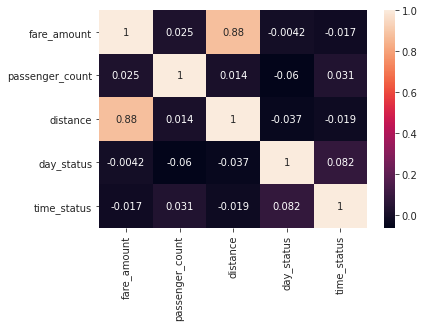

In [16]:
correlation = df.corr(method='spearman')
sns.heatmap(correlation, xticklabels=correlation.columns, yticklabels=correlation.columns, annot=True)

In [17]:
# La paleta de colores para nuestros gráficos
palette = sns.color_palette('Paired', 8)

Analizamos la cantidad de pasajeros en los viajes en taxis. Notamos que la mayor cantidad de viajes se realizan con un
solo pasajero.

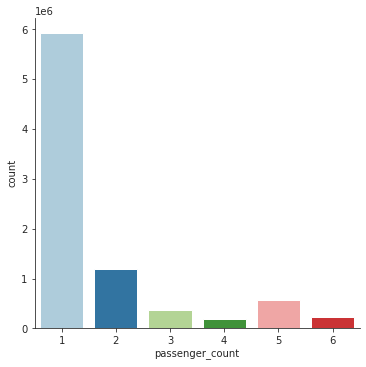

In [18]:
sns.catplot(x='passenger_count', palette=palette, kind='count', data=df)

Analizamos la cantidad de viajes que se realizan en cada momento del día. Notamos que la mayor cantidad de viajes se
realizan en la noche, y la menor cantidad de viajes se realizan en la madrugada.

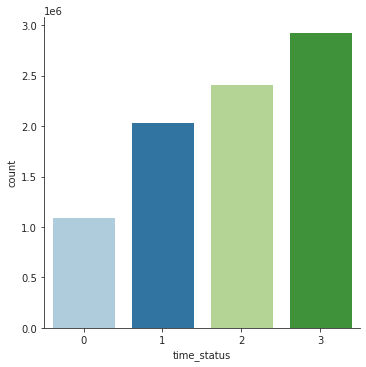

In [19]:
sns.catplot(x='time_status', palette=palette, kind='count', data=df)

Analizamos la relación entre el `fare_amount` y `distance`. Añadimos la restricción <150 porque ahí se concentra la
mayor cantidad de datos en el `distance`.

<AxesSubplot:xlabel='distance', ylabel='fare_amount'>

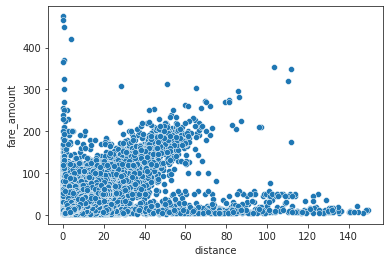

In [20]:
sns.scatterplot(x='distance', y='fare_amount', data=df[df.distance < 150])

# Creación del modelo y entrenamiento

Instalamos las dependencias necesarias para realizar el análisis

In [21]:
!pip install sklearn
!pip install xgboost

En este apartado vamos a usar cuatro modelos distintos con la finalidad de comparar y luego encontrar el mejor modelo
para nuestro dataset.

Para empezar vamos a cargar la data previamente procesada en el anterior apartado, de ese paso se obtuvo otro
subconjunto de datos más pequeño con el cual podremos trabajar los modelos.

Para ello importamos las librerías a utilizar posteriormente.

Importamos los módulos a utilizar posteriormente

```
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.neural_network import MLPRegressor

from xgboost import XGBRegressor
```

In [22]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.neural_network import MLPRegressor

from xgboost import XGBRegressor

El dataframe a utilizar lo tenemos almacenado en la variable `df` definida y procesada previamente, ahora procederemos
a generar los conjuntos de entrada y salida, en este caso la columna a predecir es `fare_amount`, por lo que realizamos
lo siguiente.

In [23]:
# Usaremos todos los datos presentes para el modelo
X = df.drop(["fare_amount"], axis=1)
y = df["fare_amount"]

# Liberamos la carga de la variable df
del df

X.shape, y.shape

((8487137, 4), (8487137,))

Ahora procederemos a separar la data de entregamiento y la data de prueba, de acuerdo a lo solicitado utilizaremos un
30% de toda la data para fines de prueba, esto lo logramos con el parámetro `test_size=0.3` en el método
`train_test_split`

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

print("Número de entradas de entrenamiento:", X_train.shape[0])
print("Número de entradas de prueba:", X_test.shape[0])

Número de entradas de entrenamiento: 5940995
Número de entradas de prueba: 2546142


## Funciones para la extracción y graficado de métricas

Esta función nos ayudará a extraer las 2 métricas más importantes de nuestro modelo el error cuadrático medio,
y el r2 score

In [1]:
# la funcion learning_curve es la encargada de mostrar la relacion de la curva de aprendizaje
# por cada lote de datos impuestos
def learning_curves(estimator, X_train_, y_train_, train_sizes, cv):
    '''
    parameters
    estimator: modelo que se usa para el entrenamiento
    X_train_ : datos de entrenamiento
    y_train_ : datos objetivo del entrenamiento
    train_sizes: lotes de entrenamiento
    cv: tecnica de división para realizar la separacion por validacion
    '''
    train_sizes, train_scores, validation_scores = learning_curve(
        estimator, X_train_, y_train_, train_sizes=train_sizes,
        cv=cv, scoring='neg_mean_squared_error')
    # extraemos la media impuesta por los datos de entrenamiento y validacion
    train_scores_mean = -train_scores.mean(axis=1)
    validation_scores_mean = -validation_scores.mean(axis=1)
    # graficamos los datos por lotes con respecto a la media
    plt.plot(train_sizes, train_scores_mean, label='Entrenamiento del error')
    plt.plot(train_sizes, validation_scores_mean, label='Validación del error')

    plt.ylabel('MSE', fontsize=14)
    plt.xlabel('Entrenamiento por lote', fontsize=14)
    title = 'Curva de aprendizaje ' + str(estimator).split('(')[0] + ' model'
    plt.title(title, fontsize=18, y=1.03)
    plt.legend()
    plt.ylim(0, 40)

In [26]:
## la funcion plotting_model sea de utilidad para tener una idea vizual del rendimiento
def plotting_model(name_model_,y_pred_,y_test_):
    '''
    parameters
    name_model_ : cadena de caracteres con el nombre del modelo
    y_pred_ : datos objetivo predichos
    y_test_: datos objetivo de prueba
    '''
    ## bound es el parametro de proporcion que usaremos para seleccionar ciertos datos
    bound = 10000
    fig = plt.figure(figsize=(20,5))
    plt.title(f"Visualización de datos reales sobre predichos por {name_model_}")
    # usando y_test_[::bound] estamos sacando todos los valores con indice multiplo de bound
    # graficamos una barra de da datos sobre los datos reales
    plt.bar(list(range(len(y_test_[::bound]))), y_test_.values[::bound],
        alpha = 0.5, color = 'red', width = 1, label = 'Valores reales')
    # graficamos una barra de da datos sobre los datos predichos
    plt.bar(list(range(len(y_pred_[::bound]))), y_pred_[::bound],
        alpha = 0.7, color = 'blue', width = 1, label = 'Valores predichos')
    plt.legend()
    plt.show()

In [27]:
## Usaremos una función para extraer las métricas del modelo y graficar algunas comparaciones
def model_metric(model_, X_test_, y_test_, name_model_):
    '''
    parameters
    mode_ : modelo que se usa 
    X_test_: datos de prueba
    y_test_: datos objetivo
    name_model_: nombre del modelo
    
    return: model_mse, model_r2
    '''
    print(f"Métricas de modelo {name_model_}")
    y_predict = model_.predict(X_test_)
    print("Graficando...")
    plotting_model(name_model_,y_predict,y_test_)
    # nuestra metricas son mse y r2 por lo que las ejecutamos y mostramos su resultado
    model_mse = np.sqrt(mean_squared_error(y_test_, y_predict))
    model_r2 = r2_score(y_test_, y_predict)
    print(f"El error cuadrático medio de {name_model_} es:", model_mse)
    print(f"La métrica r2 score de {name_model_} es:", model_r2)
    return model_mse,model_r2

## Obtención de métricas para diferentes modelos

Utilizaremos 4 modelos, al ser data continua optamos por utilizar regresores.

In [28]:
name_model = []
model = []

## Linear Regression
lm = LinearRegression(normalize=False, fit_intercept=True)
name_model.append('Linear Regression')
model.append(lm)

## AdaBoost Regressor
ada = AdaBoostRegressor()
name_model.append('AdaBoost Regressor')
model.append(ada)

## RandomForest Regressor
n_estimators=10
rf = RandomForestRegressor(n_estimators=n_estimators)
name_model.append('RandomForest Regressor')
model.append(rf)

## XGBoost Regressor
xgbr = XGBRegressor()
name_model.append('XGBoost Regressor')
model.append(xgbr)


### Linear Regression
- Entrenando...
Métricas de modelo Linear Regression
Graficando...


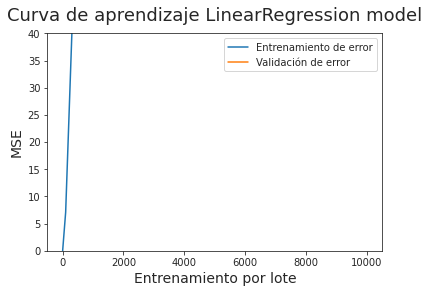

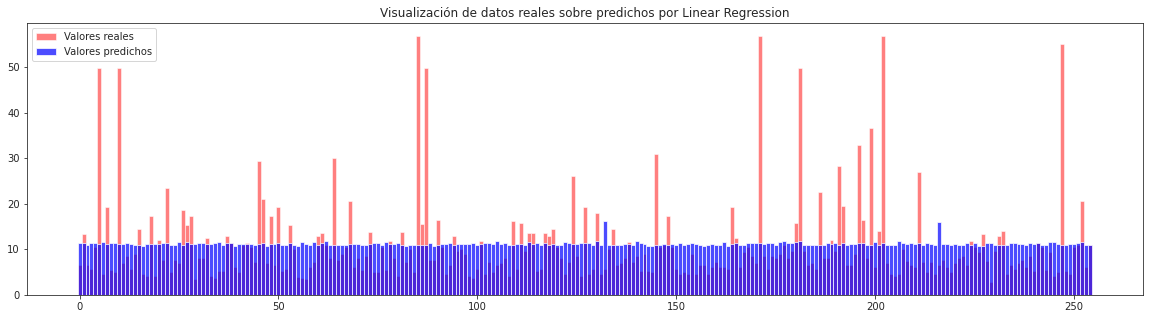

El error cuadrático medio de Linear Regression es: 9.174233854744276
La métrica r2 score de Linear Regression es: 0.0011504021397289454

### AdaBoost Regressor
- Entrenando...
Métricas de modelo AdaBoost Regressor
Graficando...


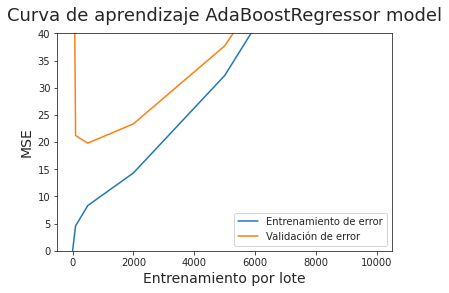

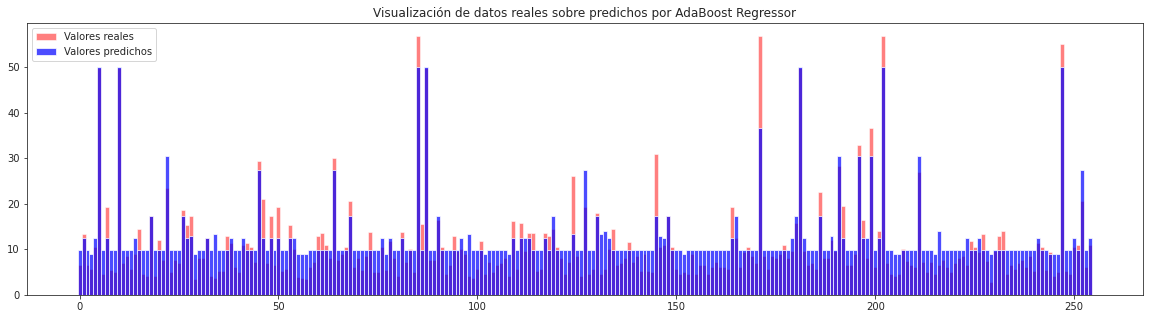

El error cuadrático medio de AdaBoost Regressor es: 4.849442734246422
La métrica r2 score de AdaBoost Regressor es: 0.7209100762500255

### RandomForest Regressor
- Entrenando...
Métricas de modelo RandomForest Regressor
Graficando...


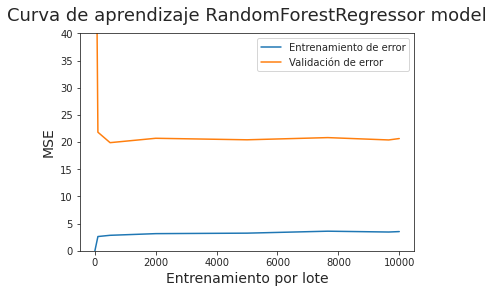

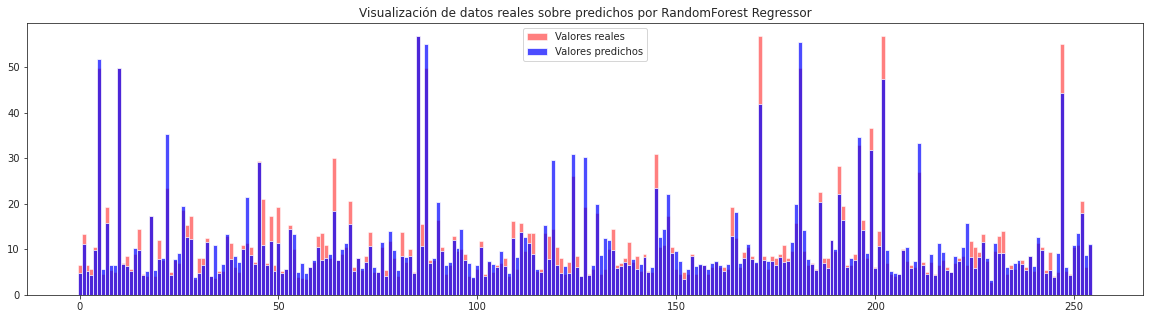

El error cuadrático medio de RandomForest Regressor es: 4.553681616913966
La métrica r2 score de RandomForest Regressor es: 0.75391462081787

### XGBoost Regressor
- Entrenando...
Métricas de modelo XGBoost Regressor
Graficando...


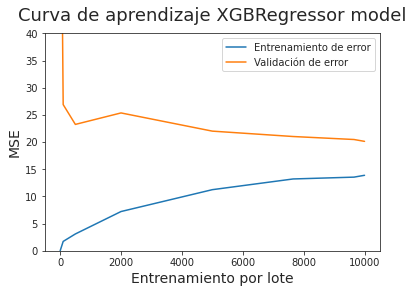

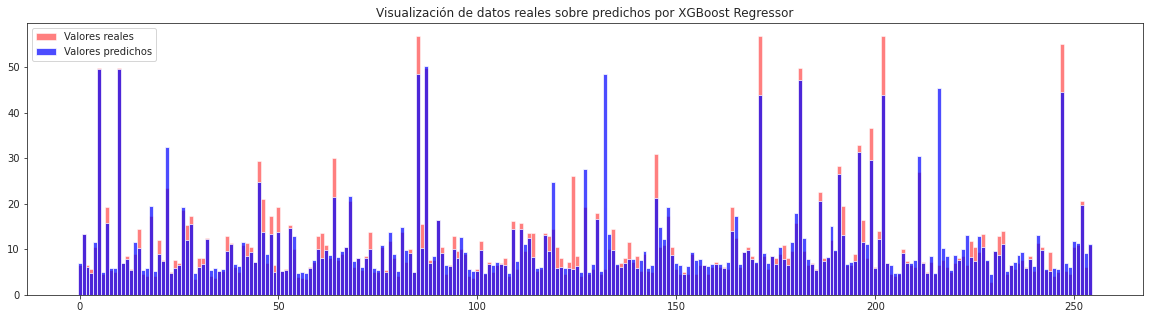

El error cuadrático medio de XGBoost Regressor es: 4.16231260000011
La métrica r2 score de XGBoost Regressor es: 0.7943967979982318


In [29]:
# Iteramos sobre cada uno de los modelos

results = []

for nam_model, _model in zip(name_model, model):
    print(f"\n### {nam_model}")
    print("- Entrenando...")
    _model.fit(X_train, y_train)
    learning_curves(_model, X_train, y_train, [1, 100, 500, 2000, 5000, 7654, 9654, 10000], 5)
    # almacenamos los resultados de las metricas para el siguente grafica
    results.append((model_metric(_model, X_test, y_test, nam_model), nam_model))

## Comparación de los modelos

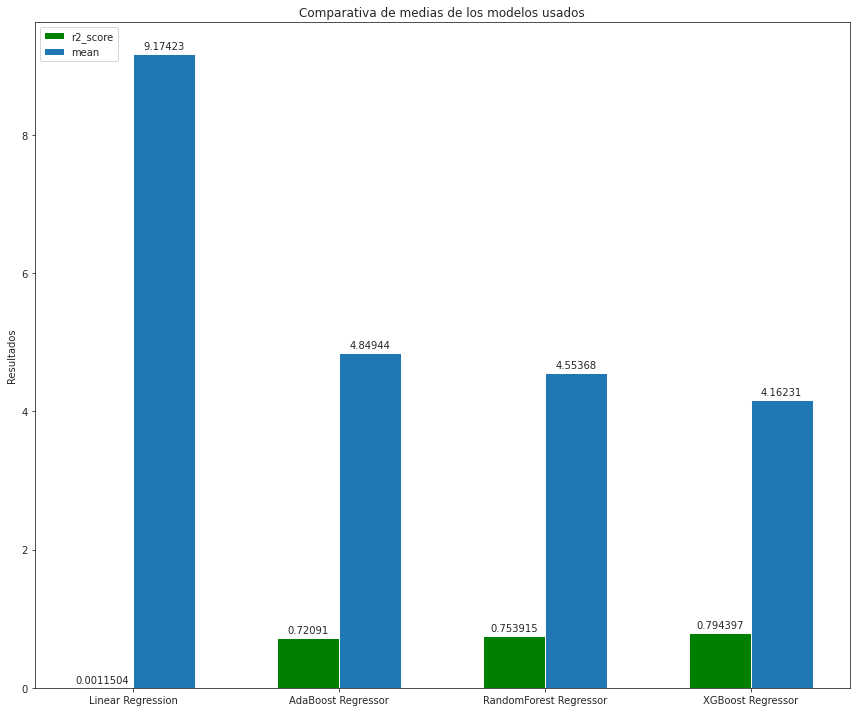

In [30]:
## Extraemos los resultados
labels = []
r2_score = []
mean = []
for data in results:
    labels.append(data[1])
    r2_score.append(data[0][1])
    mean.append(data[0][0])

fig, ax = plt.subplots(figsize=(12, 10))
# asignamos un ancho pa las barras
width = 0.3
x = np.arange(len(labels))
# barras de r2_score colo verde
rects1 = ax.bar(x - width / 2, r2_score, width, label='r2_score', color='green')
# barras de la media color azul
rects2 = ax.bar(x + width / 2, mean, width, label='mean')

ax.set_ylabel('Resultados')
ax.set_title('Comparativa de medias de los modelos usados')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='upper left')

ax.bar_label(rects1, padding=3)

ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

## Resultados

Como se puede observar en la gráfica previa, el modelo que tuvo mejores métricas tanto para el r2-score como el error cuadrático medio fue **XGBoost Regressor** con valores `0.794397` y `4.16231` respectivamente el mejor modelo.
Ademas, viendo las graficas de validacion y entrenamiento, no cualquier modelo sera de utilidad para estos datos, dando como resultados incoherentes como en **Linear Regressor**, se puede ver la convergencia entre el MSE unicamente en **XGBoost Regressor** quien podria hacerlo mejor si disminuimos el numero de estimadores, en **RandomForest Regressor** se puede ver que existe un lento aprendizaje  quiza se debe ajustar el numero de estimadores.